<center><big><b>CSE 5524 – Project

<center><big> Soccer Ball Detection

In [1]:
import skimage 
from skimage import io 
import numpy as np 
import matplotlib.pyplot as plt
import math
import cv2
import scipy.ndimage
from scipy.linalg import eigh
import matplotlib.patches as patches

### Covarience Tracking

- Load targets

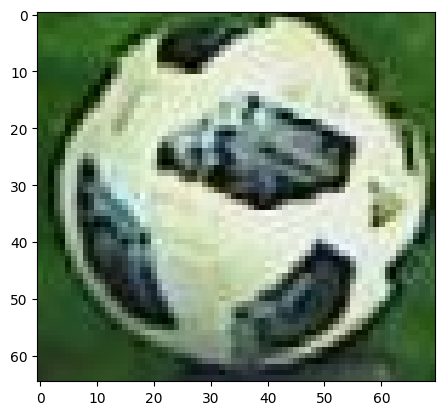

(65, 70, 3)


In [2]:
target = skimage.io.imread('target.jpg')
plt.imshow(target)
plt.show()
print(target.shape)

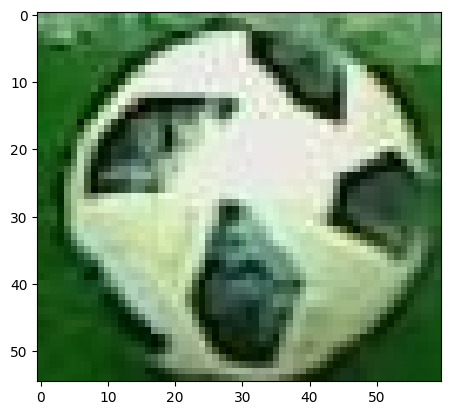

(55, 60, 3)


In [3]:
target2 = skimage.io.imread('target2.jpg')
plt.imshow(target2)
plt.show()
print(target2.shape)

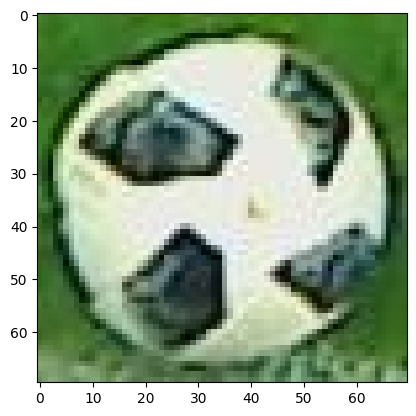

(70, 70, 3)


In [68]:
target3 = skimage.io.imread('target3.jpg')
plt.imshow(target3)
plt.show()
print(target3.shape)

In [4]:
def covarience_tracking(im, target):
    features = []

    # Build covariance matrix
    for y in range(target.shape[0]):
        for x in range(target.shape[1]):
            r, g, b = target[y, x]
            features.append([x, y, r, g, b]) 

    features_array = np.array(features)
    cov_matrix = np.cov(features_array.T) 

#     print("Covariance Matrix:")
#     print(cov_matrix)
    model_cov = cov_matrix
    
    
    # Covariance tracking
    height, width, _ = im.shape
    window_rows, window_cols,_ = target.shape
    y, x = np.arange(window_rows).astype(np.float32), np.arange(window_cols).astype(np.float32)
    yv, xv = np.meshgrid(y, x, indexing='ij')
    yv, xv  = yv.flatten()[np.newaxis, :], xv.flatten()[np.newaxis, :]

    R, G, B = im[:, :, 0].astype(np.float32), im[:, :, 1].astype(np.float32), im[:, :, 2].astype(np.float32)

    # Calculate and save the match distance
    dists = np.zeros((height - window_rows, width - window_cols), dtype=np.float32)
    for i in range(height - window_rows):
        for j in range(width - window_cols):
            feat = np.vstack((xv, yv,
                              R[i:i+window_rows, j:j+window_cols].flatten()[np.newaxis, :],
                              G[i:i+window_rows, j:j+window_cols].flatten()[np.newaxis, :],
                              B[i:i+window_rows, j:j+window_cols].flatten()[np.newaxis, :]))
            candidate_cov = np.cov(feat, bias=True)
            eigvals = eigh(model_cov, candidate_cov, eigvals_only=True)
            dist = np.sqrt((np.log(eigvals)**2).sum())
            dists[i, j] = dist
#     print(dists.shape)
    
    # Find the best match box
    minDiff = dists.argmin()
    minpos = minDiff // (width - window_cols), minDiff % (width - window_cols)
    return minDiff, minpos

In [5]:
def covarience_tracking_robust(im, target, target2):
    
    # Select the best match beteen two targets and make it robust
    minDiff1, minpos1 = covarience_tracking(im, target)
    minDiff2, minpos2 = covarience_tracking(im, target2)
    if minDiff1 <= minDiff2:
        fig,ax = plt.subplots()
        ax.imshow(im)
        rect = patches.Rectangle((minpos1[1],minpos1[0]),target.shape[1],target.shape[0],linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        plt.show()
    else:
        fig,ax = plt.subplots()
        ax.imshow(im)
        rect = patches.Rectangle((minpos2[1],minpos2[0]),target2.shape[1],target2.shape[0],linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        plt.show()


In [6]:
def ncc_tracking(im, target):
   #Dimensions of the images
    im_height, im_width, _ = im.shape
    target_height, target_width, _ = target.shape

    #Initialize
    max_corr = -1
    max_pos = (0, 0)

    #Normalize the target
    target_mean = target.mean()
    target_std = target.std()
    target_normalized = (target - target_mean) / target_std

    for y in range(im_height - target_height + 1):
        for x in range(im_width - target_width + 1):
            # Extract sub-image
            sub_im = im[y:y + target_height, x:x + target_width]

            # Normalizing the sub-image
            sub_im_mean = sub_im.mean()
            sub_im_std = sub_im.std()
            sub_im_normalized = (sub_im - sub_im_mean) / sub_im_std

            ncc = np.sum(sub_im_normalized * target_normalized) / (target_height * target_width)

            if ncc > max_corr:
                max_corr = ncc
                max_pos = (x, y)

    return ncc, max_pos

In [75]:
def ncc_tracking_demo():
    imDemo = []
    imDemo.append(skimage.io.imread('Dataset/image0.jpg'))
    imDemo.append(skimage.io.imread('Dataset/image596.jpg'))
    imDemo.append(skimage.io.imread('Dataset/image794.jpg'))
    
    targetDemo = skimage.io.imread('target.jpg')

    for i in range(len(imDemo)):
        nccDemo, nccPos = ncc_tracking(imDemo[i], targetDemo)

        fig, ax = plt.subplots()
        ax.imshow(imDemo[i])
        rect = patches.Rectangle((nccPos[0], nccPos[1]), targetDemo.shape[0], targetDemo.shape[1], linewidth=1, edgecolor='r',
                                    facecolor='none')
        ax.add_patch(rect)
        plt.show()

In [69]:
def ncc_tracking_robust(im, target, target2):
    ncc_1, max_pos_1 = ncc_tracking(im, target)
    ncc_2, max_pos_2 = ncc_tracking(im, target2)
    
    print("NCC1:")
    print(ncc_1,max_pos_1[0],max_pos_1[1])
    print("NCC2:")
    print(ncc_2,max_pos_2[0],max_pos_2[1])

#     if ncc_1 > ncc_2:
#         best_ncc = ncc_1
#         best_pos = max_pos_1
#         best_target = target
#     else:
#         best_ncc = ncc_2
#         best_pos = max_pos_2
#         best_target = target2

    best_ncc = ncc_1
    best_pos = max_pos_1
    best_target = target
    fig,ax = plt.subplots()
    ax.imshow(im)
    rect = patches.Rectangle((best_pos[0], best_pos[1]),best_target.shape[0],best_target.shape[1],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()
    
    best_ncc = ncc_2
    best_pos = max_pos_2
    best_target = target2
    fig,ax = plt.subplots()
    ax.imshow(im)
    rect = patches.Rectangle((best_pos[0], best_pos[1]),best_target.shape[0],best_target.shape[1],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()


### Covariance Test Case 1

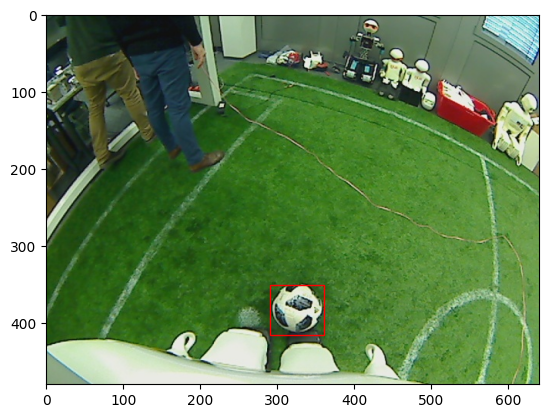

In [7]:
im = skimage.io.imread('Dataset/image0.jpg')
covarience_tracking_robust(im, target, target2)

### Covariance Test Case 2

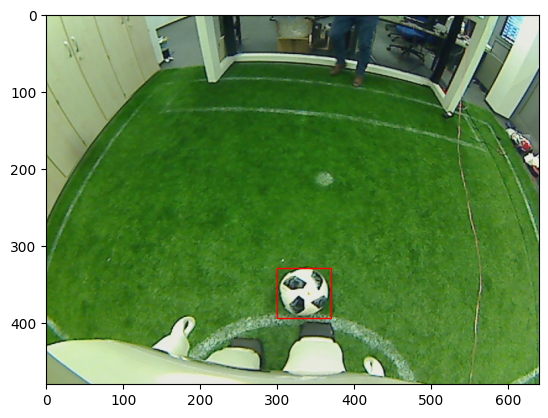

In [8]:
im2 = skimage.io.imread('Dataset/image596.jpg')
covarience_tracking_robust(im2, target, target2)

### Covariance Test Case 3

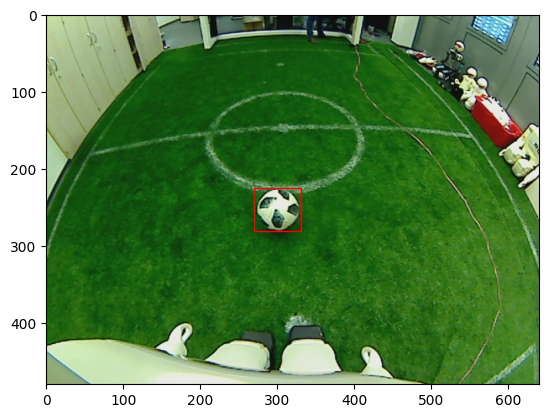

In [66]:
im3 = skimage.io.imread('Dataset/image794.jpg')
covarience_tracking_robust(im3, target, target2)

### NCC Test Cases

NCC1:
0.5097694932822283 270 220
NCC2:
0.7589901207552663 270 225


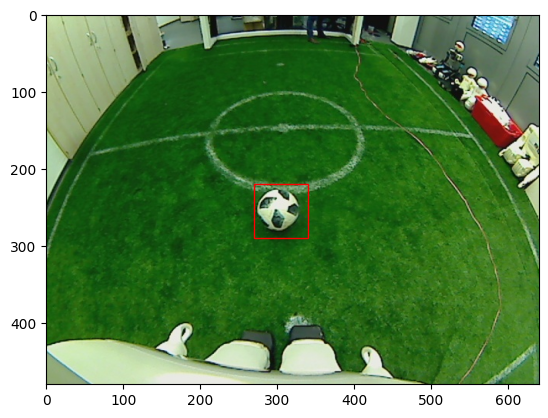

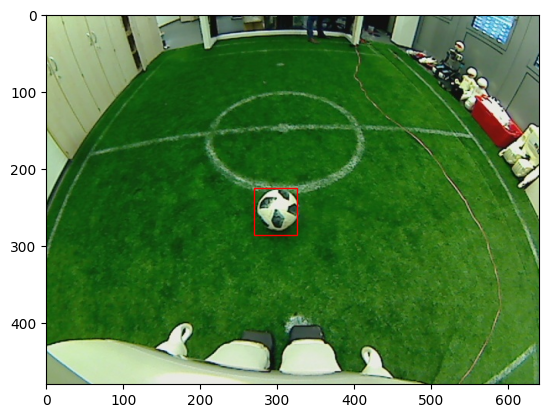

In [70]:
ncc_tracking_robust(im3, target3, target2)

NCC1:
0.27001426948092355 287 326
NCC2:
0.3503285221685803 300 325


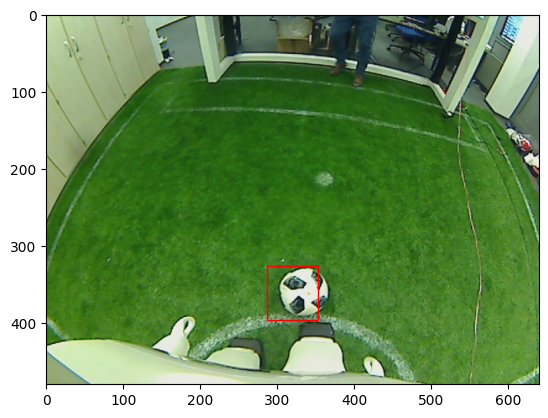

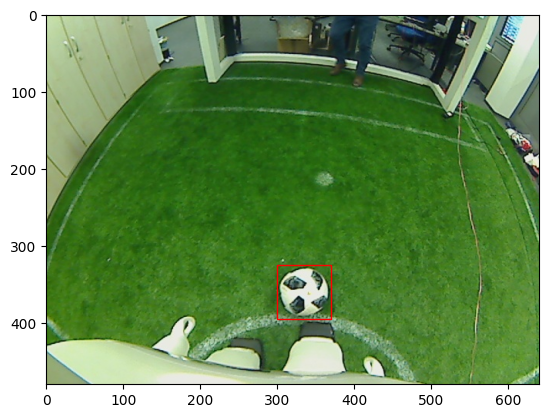

In [73]:
ncc_tracking_robust(im2, target, target3)

NCC1:
0.4613614264334127 181 73
NCC2:
0.2720382607093817 290 350


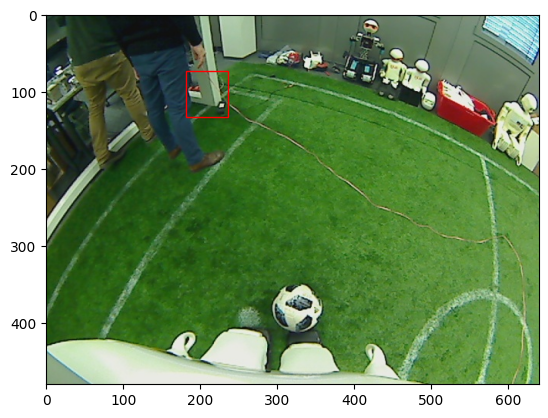

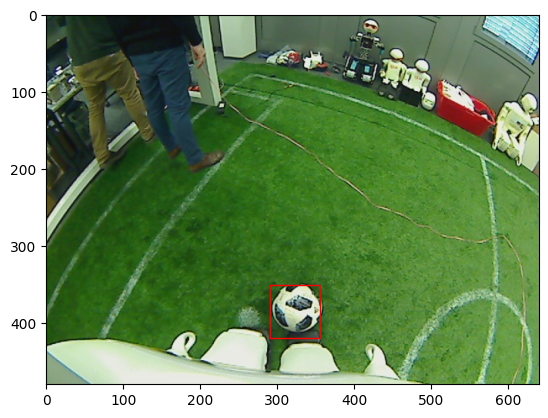

In [74]:
ncc_tracking_robust(im, target2, target)